In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import glob

In [11]:
!pip install protfasta

In [12]:
import protfasta

In [2]:
#paddle = pd.read_csv('/Users/pooja/Desktop/research/staller/PAX5_Q02548_AD_304-358_40_tile_replaced_paddle.csv')
paddle = pd.read_csv('/Users/pooja/Downloads/gcn4_s288c_tiled_replaced_paddle_preds.csv')
paddle['tile'] = paddle['id'].str.split("_").str[-1].str[4:].astype('int')
paddle["position"] = paddle["id"].str.split('(').str[1].str.extract("\w{3}(\d+)\w{3}")[0].astype("int")
only_wt = paddle[paddle['id'].str.contains('wt')]
no_wt = paddle[~paddle['id'].str.contains('wt')]
paddle_difference = no_wt.merge(only_wt[['tile', 'position', 'preds']], how = 'left', on = ['tile', 'position'])
paddle_difference = paddle_difference.rename(columns = {'preds_x':'pred_mutated', 'preds_y':'pred_reference'})
paddle_difference['pred_difference'] = paddle_difference['pred_mutated'] - paddle_difference['pred_reference']
paddle_difference['fold_difference'] = paddle_difference['pred_mutated'] / paddle_difference['pred_reference']
paddle_difference


FileNotFoundError: [Errno 2] No such file or directory: '/Users/pooja/Downloads/gcn4_s288c_tiled_replaced_paddle_preds.csv'

In [14]:
dfs = [paddle_difference]
for df in dfs:
    df["orig_AA"] = df["id"].str.extract(r'p\.(...)')
    df["new_AA"] = df["id"].str.extract(r'p\.\w{3}\d+(\w{3})')

    # Converting to 1 letter code
    aa_dict = {
        'Ala': 'A', 'Arg': 'R', 'Asn': 'N', 'Asp': 'D', 'Cys': 'C',
        'Glu': 'E', 'Gln': 'Q', 'Gly': 'G', 'His': 'H', 'Ile': 'I',
        'Leu': 'L', 'Lys': 'K', 'Met': 'M', 'Phe': 'F', 'Pro': 'P',
        'Ser': 'S', 'Thr': 'T', 'Trp': 'W', 'Tyr': 'Y', 'Val': 'V'
    }

    df["orig_AA"] = df["orig_AA"].map(aa_dict)
    df["new_AA"] = df["new_AA"].map(aa_dict)


/var/folders/xn/r640zw154sb45g5srg4fzrrr0000gp/T/ipykernel_64998/1656549813.py:39: FutureWarning: The provided callable <function mean at 0x10586dc10> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = dfs[i].pivot_table(values='pred_difference', columns='tile', index='new_AA', aggfunc = np.mean)


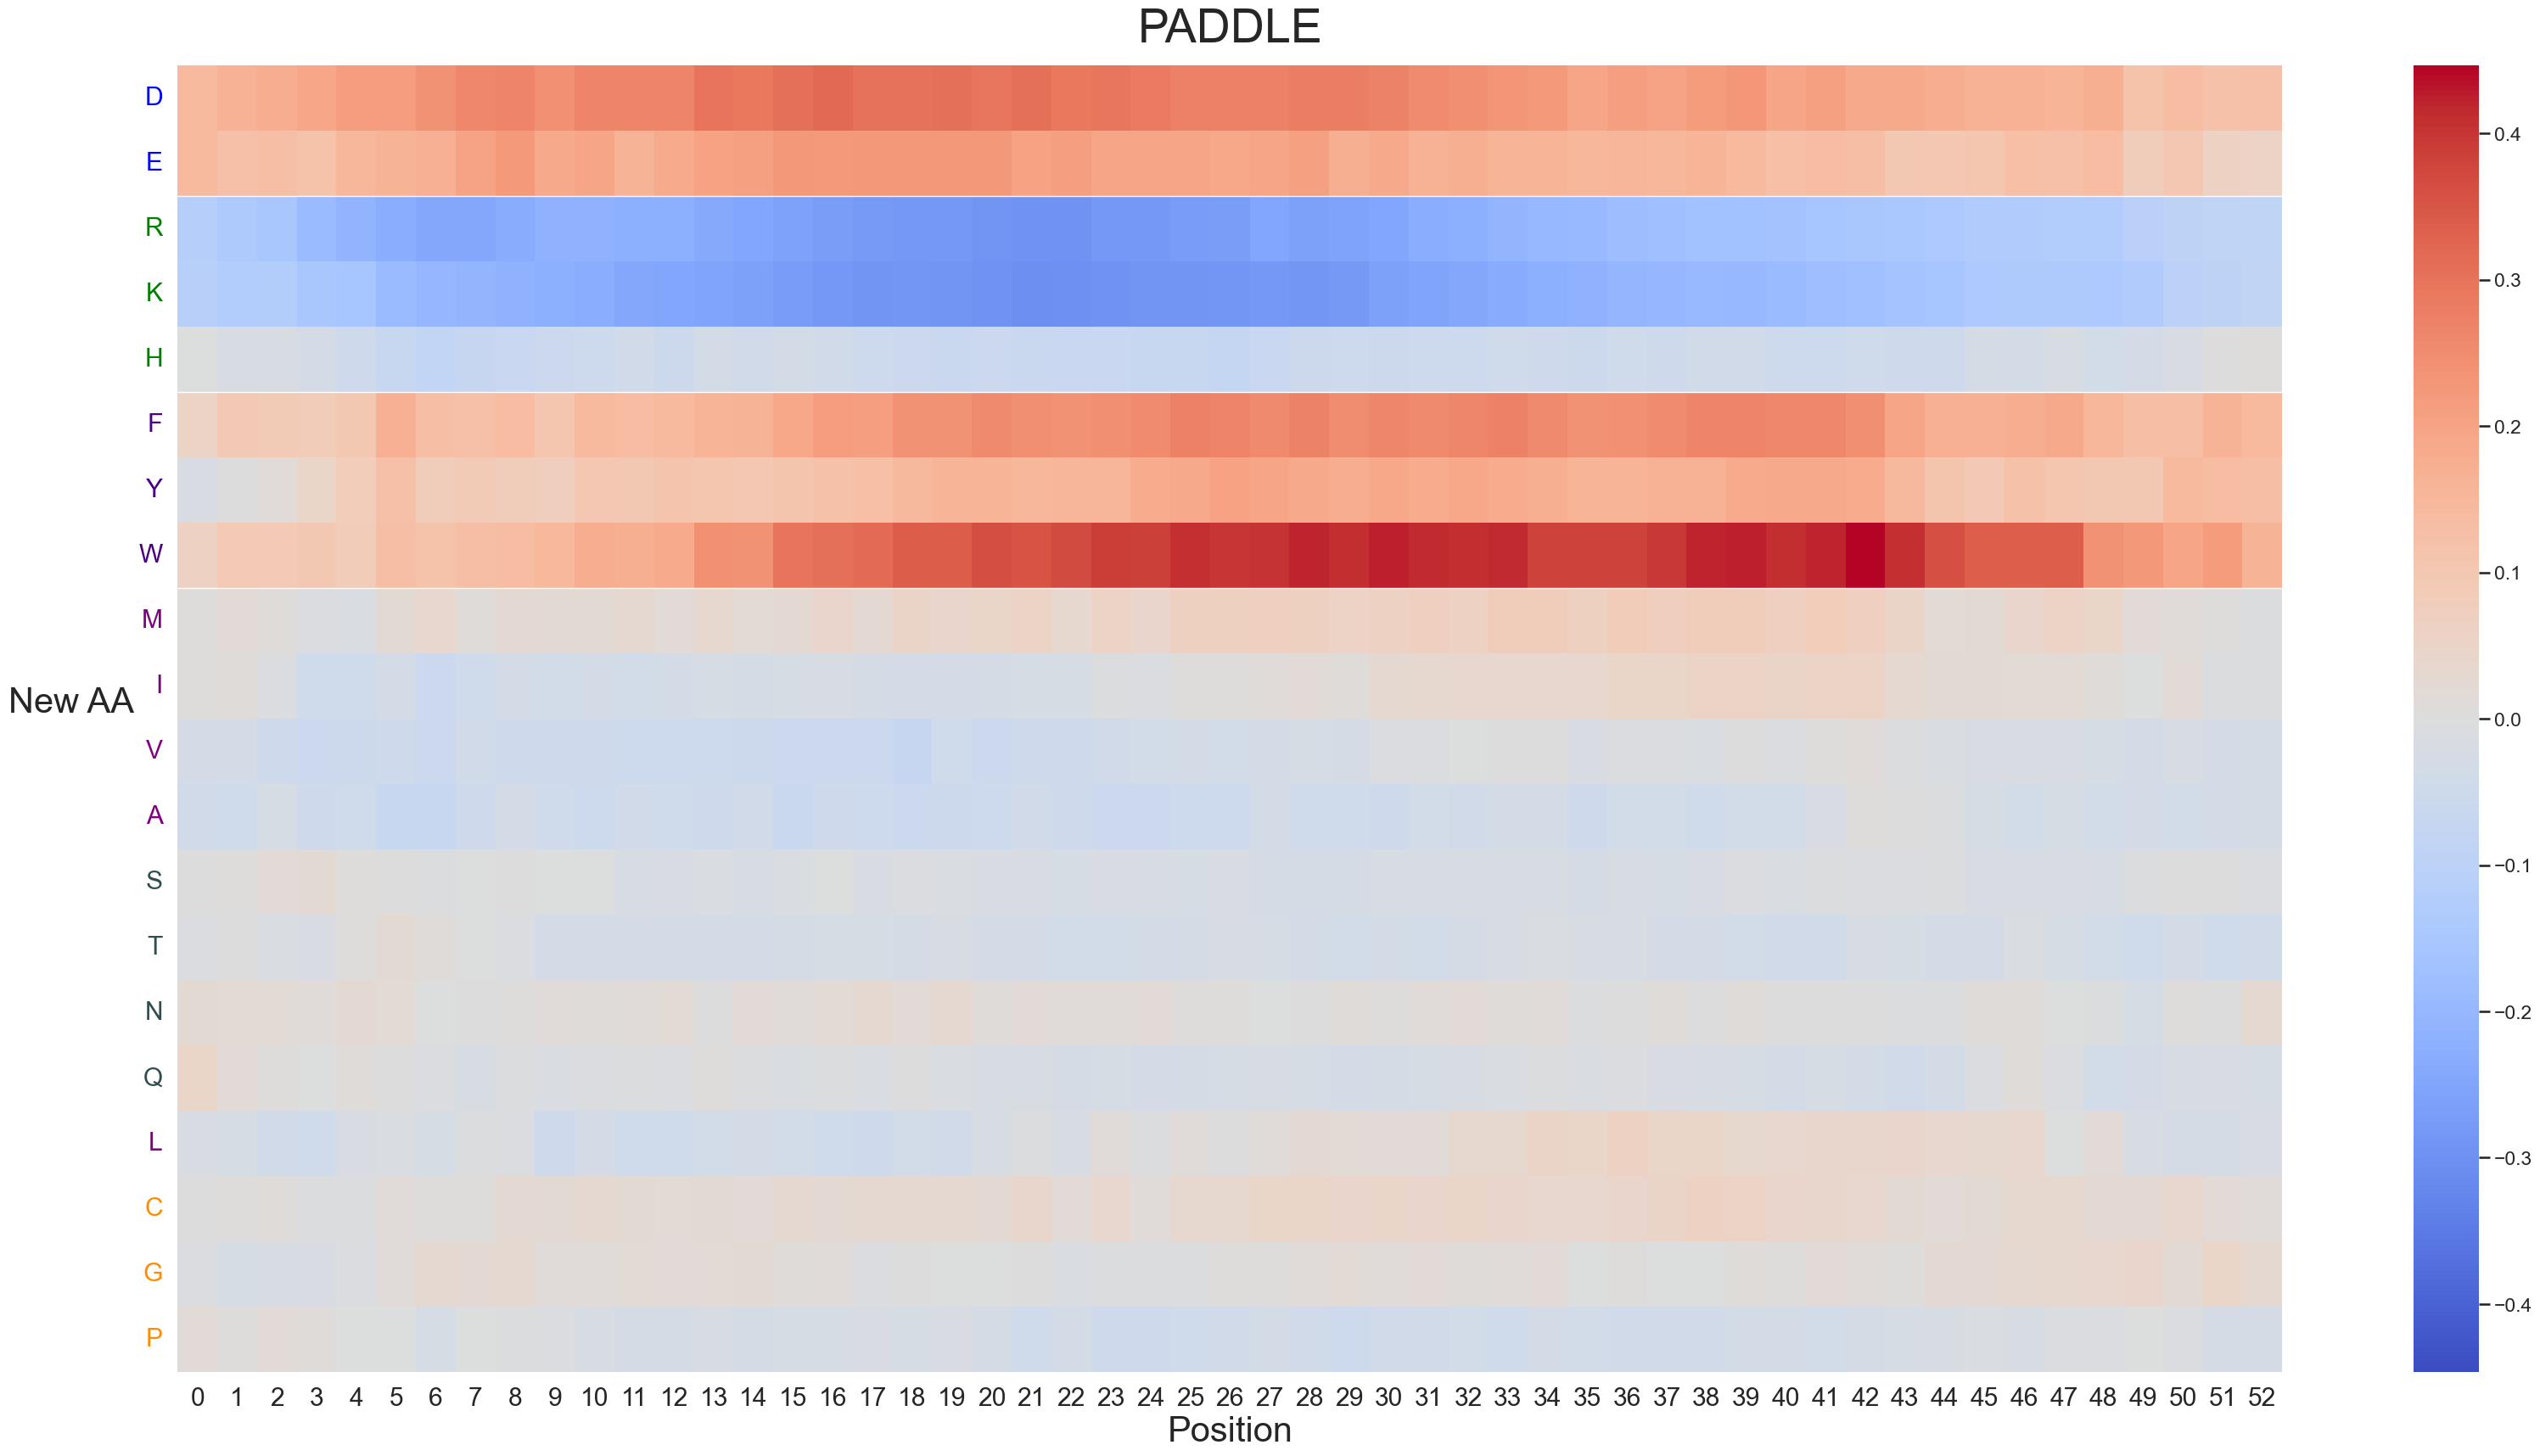

In [15]:
from matplotlib.colors import LinearSegmentedColormap

fig, axs = plt.subplots(1, 1, figsize=(40, 20))
sns.set_context('talk')
#plt.figure(dpi = 300)
#plt.style.use("dark_background")
sns.set_style("white")
df_names = ['PADDLE']

AA_order = ["D", "E", "R", "K", "H", "F", "Y", "W", "M", "I", "V", "A", "S", "T", "N", "Q", "L", "C", "G", "P"]

de_color = sns.color_palette('pastel')[-1]
rk_color = sns.color_palette('pastel')[3]
wfyl_color = sns.color_palette('pastel')[2]
other_color = sns.color_palette('pastel')[-3]

colors = [de_color, de_color,
            rk_color, rk_color, rk_color,
            wfyl_color, wfyl_color,
            wfyl_color, other_color, 
            other_color, other_color, 
            other_color, other_color, 
            other_color, other_color, 
            other_color, other_color, 
            other_color, other_color, 
            other_color]

colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Red, White, Blue
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
#custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
#custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange',
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple',
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray',
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

for i in range(len(dfs)):
    pivot = dfs[i].pivot_table(values='pred_difference', columns='tile', index='new_AA', aggfunc = np.mean)
    pivot = pivot.reindex(AA_order, axis = 0)
    max_val = max(abs(pivot.min().min()), pivot.max().max())
    sns.heatmap(pivot, ax=axs, cmap='coolwarm', vmax = max_val, vmin = -max_val)
    axs.set_title(df_names[i], fontsize = 40, pad = 20)

    current_labels = axs.get_yticklabels()
    axs.set_yticklabels(current_labels, rotation=0, ha='right')
    axs.set_ylabel("New AA", rotation=0, ha = 'right', fontsize = 30)
    axs.set_xlabel("Position", rotation=0, ha = 'center', fontsize = 30)

    axs.tick_params(axis = "y", labelsize = "large", which = "major", tick1On=False, tick2On = False);
    axs.tick_params(axis = "x", labelsize = "large", which = "major", tick1On=False, tick2On = False);

    axs.axhline(2, color = "white", lw = 1, linestyle = 'solid')
    axs.axhline(5, color = "white", lw = 1, linestyle = 'solid')
    axs.axhline(8, color = "white", lw = 1, linestyle = 'solid')

    for ytick in axs.get_yticklabels():
        ytick.set_color(colors[ytick.get_text()])

    # for label in axs[i].get_yticklabels():
    #     label.set_fontweight('bold')
    # for label in axs[i].get_xticklabels():
    #     label.set_fontweight('bold')


